# DWF Flare Instrumental Distortion Correction

In [1]:
#Move up to RAFTS directory
import os
if os.getcwd().endswith('/RAFTS'):
    pass
else:
    os.chdir('../../')
    print(os.getcwd())

/Users/riley/Desktop/RAFTS


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from scipy.optimize import curve_fit

from utils import lamb_eff_md, gcd, chrDistAng
from config import *

import globals
globals.initialize()

In [3]:
flareid = globals.flareid

In [4]:
#Data Import

mjds = np.load('Outdata/times.npy')
imnames_timeordered = np.load('Outdata/imnames_timeordered.npy')
imnames_timeordered_S18 = np.load('Outdata/imnames_timeordered_S18.npy')
ras = np.load('Outdata/ras.npy')
decs = np.load('Outdata/decs.npy')

In [5]:
source = np.array([ras[:,flareid-1], decs[:,flareid-1]])
zenith = np.zeros_like(source)
center = np.zeros_like(source)

for i, (imname, imnameS18) in enumerate(zip(imnames_timeordered, imnames_timeordered_S18)):
    
    header_0 = fits.getheader(ROOTDIR + '/dwfflare/' + imname)
    data = fits.getdata(ROOTDIR + '/dwfflare/dwfflareS18/' + imnameS18)
    header = fits.getheader(ROOTDIR + '/dwfflare/dwfflareS18/' + imnameS18)
    time = Time(header['DATE-OBS'])

    zenith[0,i] = SkyCoord(AltAz(alt=90 * u.degree, az=0 * u.degree, obstime = time, location=EarthLocation.of_site('Cerro Tololo'))).transform_to(ICRS()).ra.value
    zenith[1,i] = SkyCoord(AltAz(alt=90 * u.degree, az=0 * u.degree, obstime = time, location=EarthLocation.of_site('Cerro Tololo'))).transform_to(ICRS()).dec.value

    center[0,i] = header_0['CENTRA']
    center[1,i] = header_0['CENTDEC']

In [6]:
# Calculate the great circle distances in radians
# between the source, zenith, and center coordinates

a = gcd(np.deg2rad(center[1:,]), np.deg2rad(zenith[1,:]), np.deg2rad(center[0,:]), np.deg2rad(zenith[0,:]))
b = gcd(np.deg2rad(source[1:,]), np.deg2rad(center[1,:]), np.deg2rad(source[0,:]), np.deg2rad(center[0,:]))
c = gcd(np.deg2rad(zenith[1:,]), np.deg2rad(source[1,:]), np.deg2rad(zenith[0,:]), np.deg2rad(source[0,:]))

Text(0, 0.5, 'Zenith-radial angle (deg)')

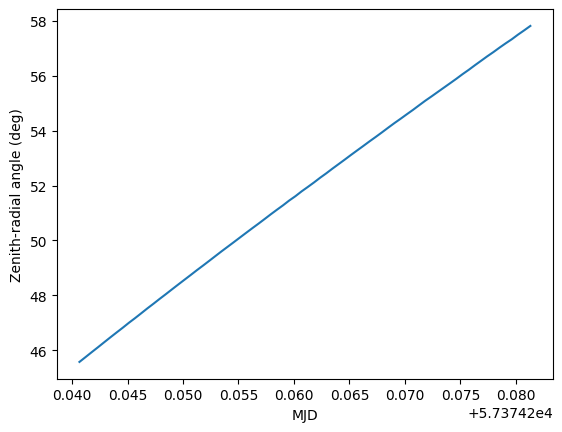

In [7]:
# Calculate the angle theta between the source-zenith arc and the source-center arc and plot it at each MJD

A = np.arccos( (np.cos(a) - np.cos(b) * np.cos(c))  / (np.sin(b) * np.sin(c)) ) 

theta = np.pi - A[0,:]

plt.plot(mjds, np.rad2deg(theta))
plt.xlabel('MJD')
plt.ylabel('Zenith-radial angle (deg)')

Text(0, 0.5, 'Zenith-radial angle (deg)')

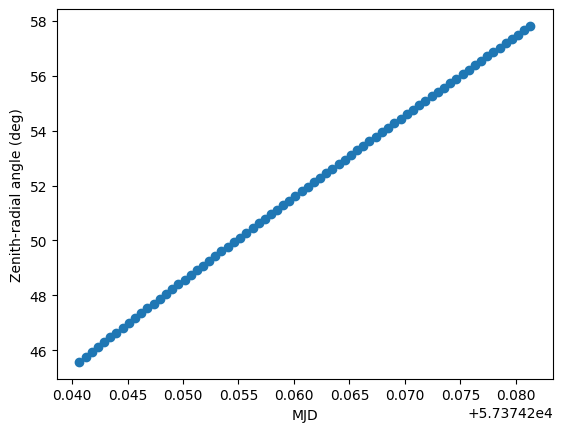

In [8]:
#We can also do this using the chrDistAng function

for i, (imname, imnameS18) in enumerate(zip(imnames_timeordered, imnames_timeordered_S18)):

    header_0 = fits.getheader(ROOTDIR + '/dwfflare/' + imname)
    data = fits.getdata(ROOTDIR + '/dwfflare/dwfflareS18/' + imnameS18)
    header = fits.getheader(ROOTDIR + '/dwfflare/dwfflareS18/' + imnameS18)
    time = Time(header['DATE-OBS'])

    theta = chrDistAng(coord = SkyCoord(ra = source[0, i] * u.deg, dec = source[1, i] * u.deg, obstime=time), header=header_0)

    plt.scatter(time.mjd, np.rad2deg(theta), color='C0')

plt.xlabel('MJD')
plt.ylabel('Zenith-radial angle (deg)')

Mean field angle = 0.579 degrees


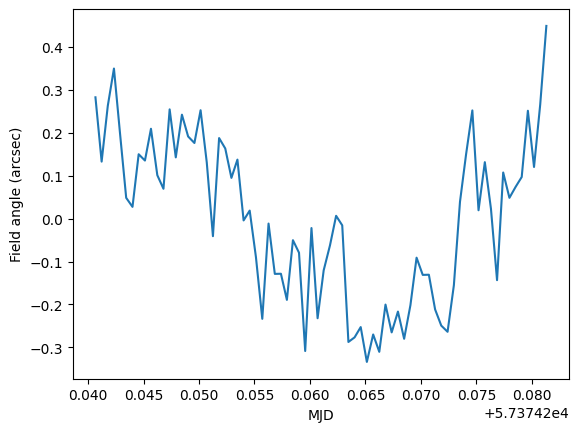

In [9]:
# Plot the field angle in arcseconds at each MJD

plt.plot(mjds, (np.rad2deg(b[0,:]) - np.rad2deg(b[0,:]).mean()) * 3600)
plt.xlabel('MJD')
plt.ylabel('Field angle (arcsec)')
print('Mean field angle = {0:.3f} degrees'.format(np.rad2deg(b[0,:]).mean()))

## Use data in config.batoid_trace to fit the distortion as function of wavelength

Text(0.5, 1.0, 'Chromatic distortion at field angle = 0.5793 deg')

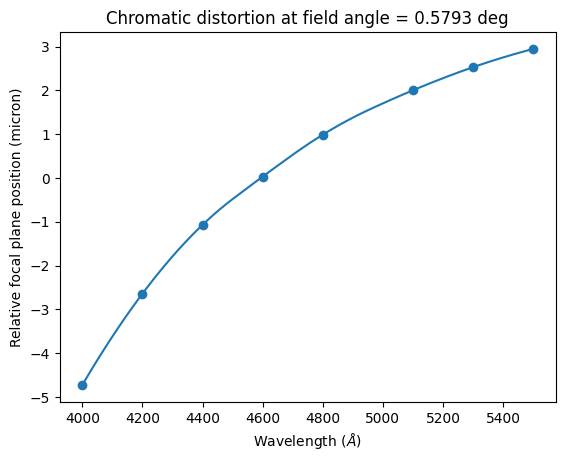

In [11]:
new_w = np.arange(4000,5500,1)
f = interp1d(x = batoid_trace[0], y=batoid_trace[1], kind='quadratic')

plt.scatter(batoid_trace[0], batoid_trace[1])
plt.plot(new_w, f(new_w))
plt.ylabel('Relative focal plane position (micron)')
plt.xlabel(r'Wavelength ($\AA$)')
plt.title('Chromatic distortion at field angle = 0.5793 deg')

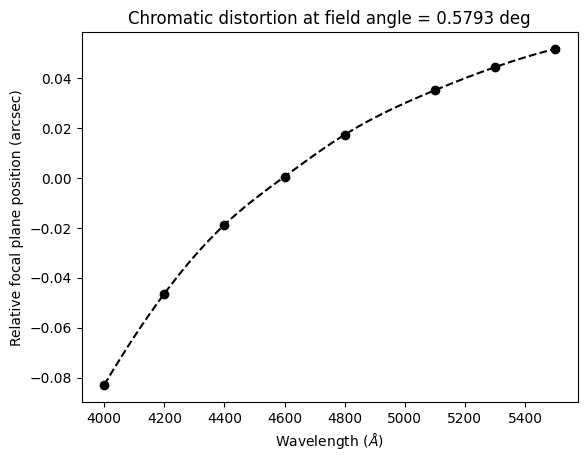

In [ ]:
#Convert from microns to arcseconds
pixpermm = 153 / 2.3
arcsecperpix = 0.2637

new_w = np.arange(4000,5500,1)
f = interp1d(x = batoid_trace[0], y=batoid_trace[1] * 1e-3 * pixpermm * arcsecperpix, kind='cubic')

plt.scatter(batoid_trace[0], batoid_trace[1] * 1e-3 * pixpermm * arcsecperpix, color='k')
plt.plot(new_w, f(new_w), color='k', ls='--')
plt.ylabel('Relative focal plane position (arcsec)')
plt.xlabel(r'Wavelength ($\AA$)')
plt.title('Chromatic distortion at field angle = 0.5793 deg');

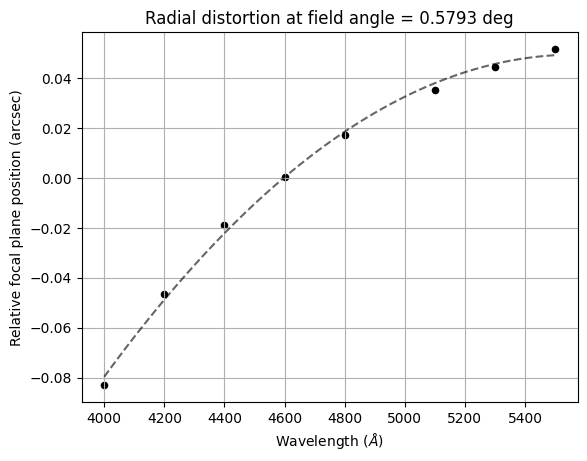

In [15]:
#Fit quadratic to the data
def func(x, a, b, c):
    return (a * x**2) + (b * x) + c

xdata = batoid_trace[0]
ydata = batoid_trace[1] * 1e-3 * pixpermm * arcsecperpix

popt, pcov = curve_fit(func, xdata, ydata)

plt.scatter(batoid_trace[0], batoid_trace[1] * 1e-3 * pixpermm * arcsecperpix, color='k', s=20)
plt.plot(new_w, func(new_w, *popt), color='k', ls='--', alpha=0.6)

plt.ylabel('Relative focal plane position (arcsec)')
plt.xlabel(r'Wavelength ($\AA$)')
plt.title('Radial distortion at field angle = 0.5793 deg')
plt.grid()
plt.savefig('/Users/riley/Desktop/RAFTS/Figures/chrdist.png', dpi=300, bbox_inches='tight')

Check magnitude of distortion at a few different blackbody temperatures

In [18]:
q_weff = lamb_eff_md('g', temp=0.0, mdpath = ROOTDIR + '/sdsstemplates/m7.active.ha.na.k_ext.npy')
'Chromatic distortion at quiescence = {} arcsec'.format(f(new_w)[np.where(abs(new_w - q_weff) == abs(new_w - q_weff).min())][0])

'Chromatic distortion at quiescence = 0.03180992304807411 arcsec'

In [21]:
t = 10000
n_weff = lamb_eff_md('g', temp=t)
'Chromatic distortion at {0}K (Eff wavelength = {1:.2f}A) = {2} arcsec'.format(t, n_weff, f(new_w)[np.where(abs(new_w - n_weff) == abs(new_w - n_weff).min())][0])

'Chromatic distortion at 10000K (Eff wavelength = 4772.24A) = 0.01517037694537195 arcsec'

In [22]:
t = 40000
n_weff = lamb_eff_md('g', temp=t)
'Chromatic distortion at {0}K (Eff wavelength = {1:.2f}A) = {2} arcsec'.format(t, n_weff, f(new_w)[np.where(abs(new_w - n_weff) == abs(new_w - n_weff).min())][0])

'Chromatic distortion at 40000K (Eff wavelength = 4677.19A) = 0.007285309338143406 arcsec'